# `CNRatioModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `CNRatioModel` model. The `CNRatioModel` models the hyperfine spectral structure of 12CN and 13CN spectra in order to determine the physical conditions of the emitting gas, including the 12C/13C isotopic ratio. This notebook demonstrates this model and is otherwise nearly identical to the `HFSModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.5.0+6.g3c38c15
bayes_cn_hfs version: 0+untagged.1.g7eec682.dirty


In [2]:
# Get molecular data needed for simulating data
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
mol_data_13CN = get_molecule_data(
    "C-13-N", # molecule name in JPLSpec
    rot_state_lower = 0, # lower rotational state
)

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNRatioModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"12CN"` and `"13CN"`.

Text(0, 0.5, '$T_{B,\\,^{13}\\rm CN}$ (K)')

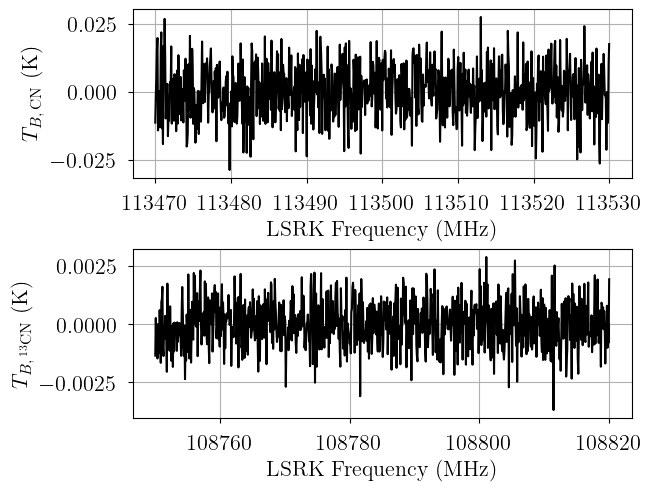

In [3]:
from bayes_spec import SpecData

# spectral axis definitions
freq_axis_12CN = np.linspace(113470, 113530, 825) # MHz
freq_axis_13CN = np.linspace(108750, 108820, 825)

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise_12CN = 0.01 # K
noise_13CN = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN = noise_12CN * np.random.randn(len(freq_axis_12CN)) # K
brightness_data_13CN = noise_13CN * np.random.randn(len(freq_axis_13CN)) # K

# Our model only expects two observations named "12CN" and "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    brightness_data_12CN,
    noise_12CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    brightness_data_13CN,
    noise_13CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
dummy_data = {"12CN": observation_12CN, "13CN": observation_13CN}

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, dummy_data["12CN"].brightness, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, dummy_data["13CN"].brightness, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
axes[1].set_ylabel(dummy_data["13CN"].ylabel)

Text(0.02, 0.5, '$T_{B,\\,\\rm CN}$ (K)')

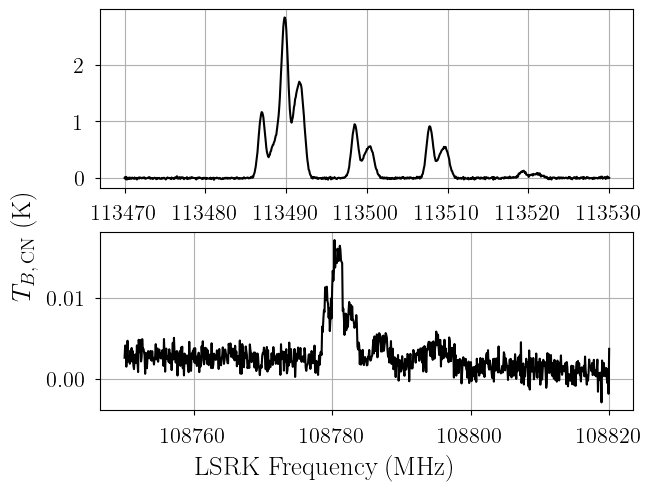

In [4]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.01, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.01, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs_12CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_baseline_coeffs_13CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N_12CN": [14.0, 13.5, 14.2],
    "log10_temp": [1.0, 1.2, 1.1],
    "nonthermal_fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
}
sim_params_12CN = sim_params.copy()
sim_params_12CN.update({
    "rms_12CN": noise_12CN,
    "12CN_baseline_norm": [-1.0, 0.5, 3.0], # normalized baseline coefficients
})
sim_params_13CN = sim_params.copy()
sim_params_13CN.update({
    "ratio_13C_12C": [0.01, 0.02, 0.005],
    "rms_13CN": noise_13CN,
    "13CN_baseline_norm": [2.0, -2.0, -3.0], # normalized baseline coefficients
})

sim_brightness_12CN = model.model["12CN"].eval(sim_params_12CN)
sim_brightness_13CN = model.model["13CN"].eval(sim_params_13CN)

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, sim_brightness_12CN, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, sim_brightness_13CN, 'k-')
fig.supxlabel(dummy_data["12CN"].xlabel)
fig.supylabel(dummy_data["12CN"].ylabel)

In [5]:
# Now we pack the simulated spectra into a new SpecData instance
observation_12CN = SpecData(
    freq_axis_12CN,
    sim_brightness_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    sim_brightness_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": observation_12CN, "13CN": observation_13CN}

## Model Definition: `CNRatioModel`

In [6]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.01, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.01, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs_12CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    prior_baseline_coeffs_13CN = [1.0, 1.0, 1.0], # width of polynomial baseline coefficients prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

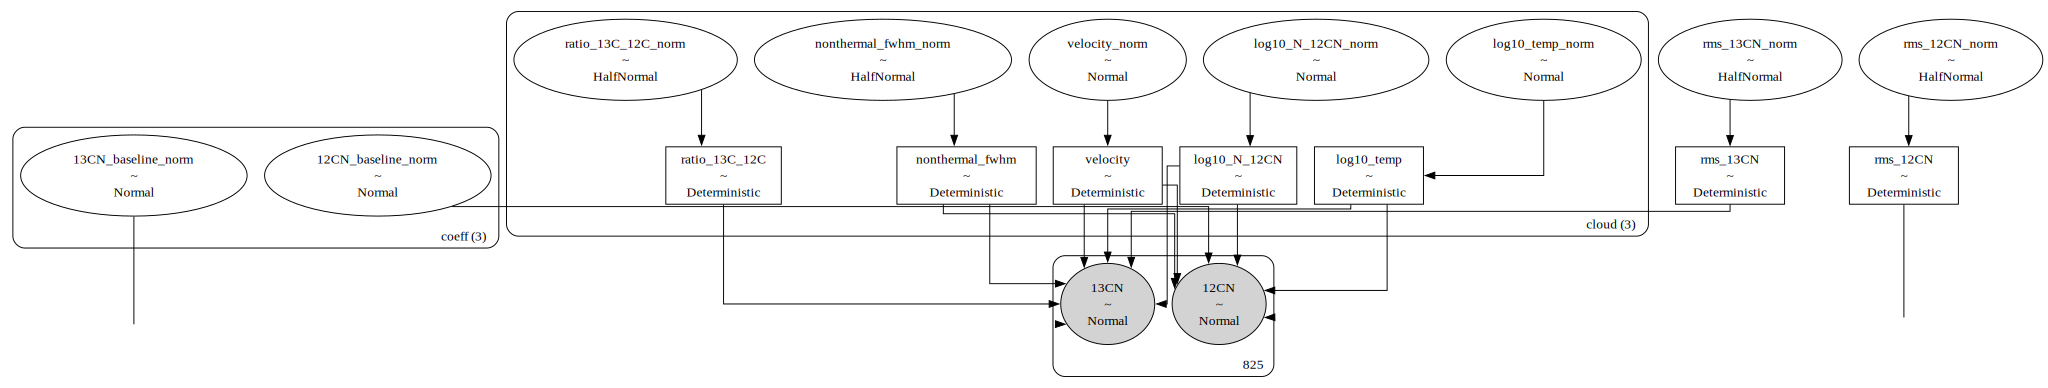

In [7]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

  12CN_baseline_norm ~ Normal(0, <constant>)
  13CN_baseline_norm ~ Normal(0, <constant>)
   log10_N_12CN_norm ~ Normal(0, 1)
     log10_temp_norm ~ Normal(0, 1)
nonthermal_fwhm_norm ~ HalfNormal(0, 1)
       velocity_norm ~ Normal(0, 1)
  ratio_13C_12C_norm ~ HalfNormal(0, 1)
       rms_12CN_norm ~ HalfNormal(0, 1)
       rms_13CN_norm ~ HalfNormal(0, 1)
        log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
          log10_temp ~ Deterministic(f(log10_temp_norm))
     nonthermal_fwhm ~ Deterministic(f(nonthermal_fwhm_norm))
            velocity ~ Deterministic(f(velocity_norm))
       ratio_13C_12C ~ Deterministic(f(ratio_13C_12C_norm))
            rms_12CN ~ Deterministic(f(rms_12CN_norm))
            rms_13CN ~ Deterministic(f(rms_13CN_norm))
                12CN ~ Normal(f(12CN_baseline_norm, log10_temp_norm, log10_N_12CN_norm, nonthermal_fwhm_norm, velocity_norm), rms_12CN)
                13CN ~ Normal(f(13CN_baseline_norm, log10_temp_norm, ratio_13C_12C_norm, log10_N_12CN_n

Sampling: [12CN, 12CN_baseline_norm, 13CN, 13CN_baseline_norm, log10_N_12CN_norm, log10_temp_norm, nonthermal_fwhm_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm, velocity_norm]


array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,^{13}\\rm CN}$ (K)'>]],
      dtype=object)

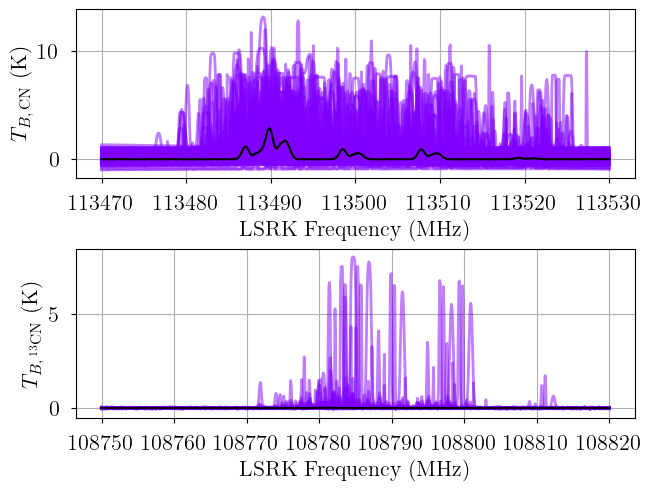

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 2.9571e+05


Runtime: 3.14 minutes


In [11]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior, var_names=model.deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],13.819,0.002,13.815,13.824,0.000,0.000,1067.0,975.0,NaN
log10_N_12CN[1],14.188,0.001,14.186,14.190,0.000,0.000,1129.0,905.0,NaN
log10_N_12CN[2],13.793,0.003,13.789,13.798,0.000,0.000,939.0,900.0,NaN
log10_temp[0],0.994,0.014,0.965,1.017,0.000,0.000,967.0,908.0,NaN
log10_temp[1],1.096,0.004,1.089,1.104,0.000,0.000,1053.0,1071.0,NaN
log10_temp[2],0.974,0.021,0.935,1.015,0.001,0.001,901.0,901.0,NaN
nonthermal_fwhm[0],2.612,0.015,2.585,2.642,0.000,0.000,1038.0,873.0,NaN
nonthermal_fwhm[1],2.454,0.005,2.443,2.464,0.000,0.000,984.0,934.0,NaN
nonthermal_fwhm[2],2.784,0.019,2.749,2.818,0.001,0.000,1033.0,920.0,NaN
velocity[0],-2.390,0.010,-2.408,-2.371,0.000,0.000,1168.0,1036.0,NaN


Sampling: [12CN, 13CN]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,^{13}\\rm CN}$ (K)'>]],
      dtype=object)

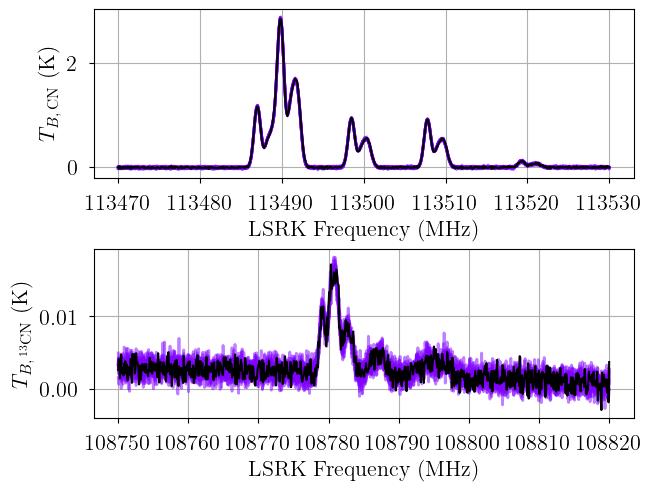

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 2.9571e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [12CN_baseline_norm, 13CN_baseline_norm, log10_N_12CN_norm, log10_temp_norm, nonthermal_fwhm_norm, velocity_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2893 seconds.


Runtime: 50.48 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [15]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],13.996,0.007,13.983,14.009,0.000,0.000,961.0,1126.0,1.01
log10_N_12CN[1],14.201,0.002,14.196,14.205,0.000,0.000,1971.0,2240.0,1.00
log10_N_12CN[2],13.473,0.040,13.402,13.551,0.001,0.001,1109.0,1583.0,1.01
log10_temp[0],1.007,0.011,0.987,1.028,0.000,0.000,3441.0,3200.0,1.00
log10_temp[1],1.101,0.007,1.089,1.114,0.000,0.000,2206.0,2473.0,1.00
log10_temp[2],1.102,0.073,0.970,1.240,0.001,0.001,2561.0,2041.0,1.00
nonthermal_fwhm[0],2.968,0.029,2.914,3.023,0.001,0.001,1010.0,1435.0,1.01
nonthermal_fwhm[1],2.508,0.007,2.496,2.520,0.000,0.000,2106.0,2975.0,1.00
nonthermal_fwhm[2],2.001,0.046,1.914,2.087,0.001,0.001,1018.0,1350.0,1.01
velocity[0],-2.013,0.022,-2.054,-1.972,0.001,0.000,965.0,1234.0,1.01


Sampling: [12CN, 13CN]


Output()

array([[<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,\\rm CN}$ (K)'>],
       [<Axes: xlabel='LSRK Frequency (MHz)', ylabel='$T_{B,\\,^{13}\\rm CN}$ (K)'>]],
      dtype=object)

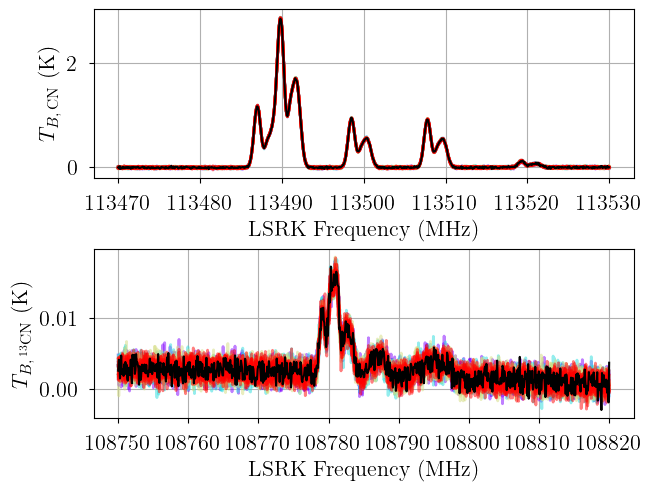

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'log10_N_12CN_norm'}>,
        <Axes: title={'center': 'log10_N_12CN_norm'}>],
       [<Axes: title={'center': 'log10_temp_norm'}>,
        <Axes: title={'center': 'log10_temp_norm'}>],
       [<Axes: title={'center': 'nonthermal_fwhm_norm'}>,
        <Axes: title={'center': 'nonthermal_fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'ratio_13C_12C_norm'}>,
        <Axes: title={'center': 'ratio_13C_12C_norm'}>],
       [<Axes: title={'center': '12CN_baseline_norm'}>,
        <Axes: title={'center': '12CN_baseline_norm'}>],
       [<Axes: title={'center': '13CN_baseline_norm'}>,
        <Axes: title={'center': '13CN_baseline_norm'}>],
       [<Axes: title={'center': 'rms_12CN_norm'}>,
        <Axes: title={'center': 'rms_12CN_norm'}>],
       [<Axes: title={'center': 'rms_13CN_norm'}>,
        <Axes: title={'center': 'rms_13CN_norm'}>]], dtype=object)

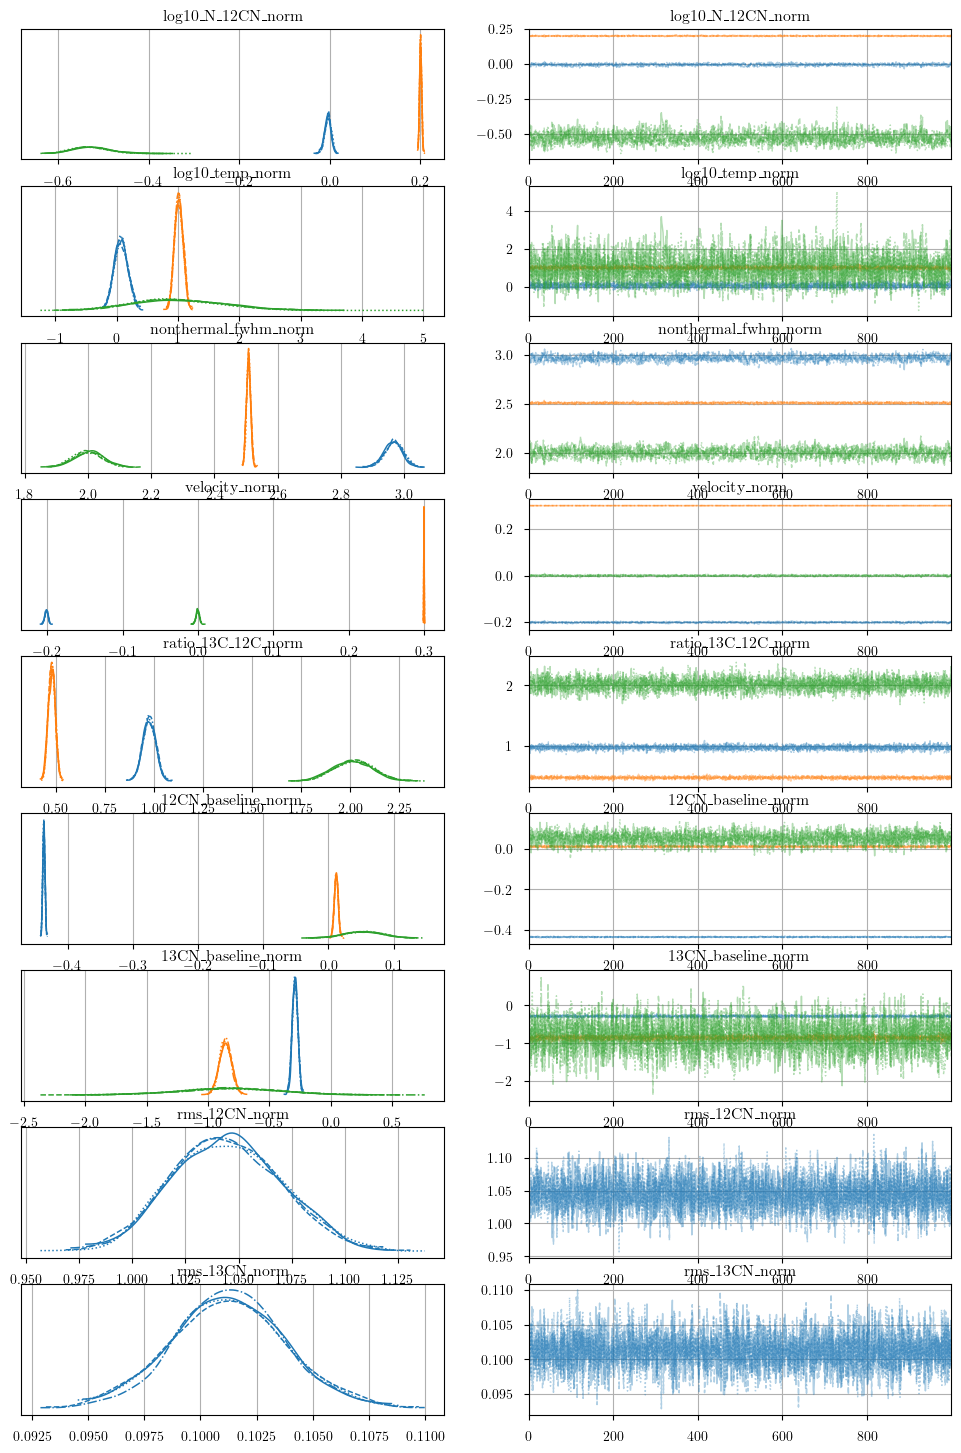

In [17]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log10_temp_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='nonthermal_fwhm_norm'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='velocity_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='log10_N_12CN_norm', ylabel='ratio_13C_12C_norm'>,
        <Axes: xlabel='log10_temp_norm'>,
        <Axes: xlabel='nonthermal_fwhm_norm'>,
        <Axes: xlabel='velocity_norm'>,
        <Axes: xlabel='ratio_13C_12C_norm'>]], dtype=object)

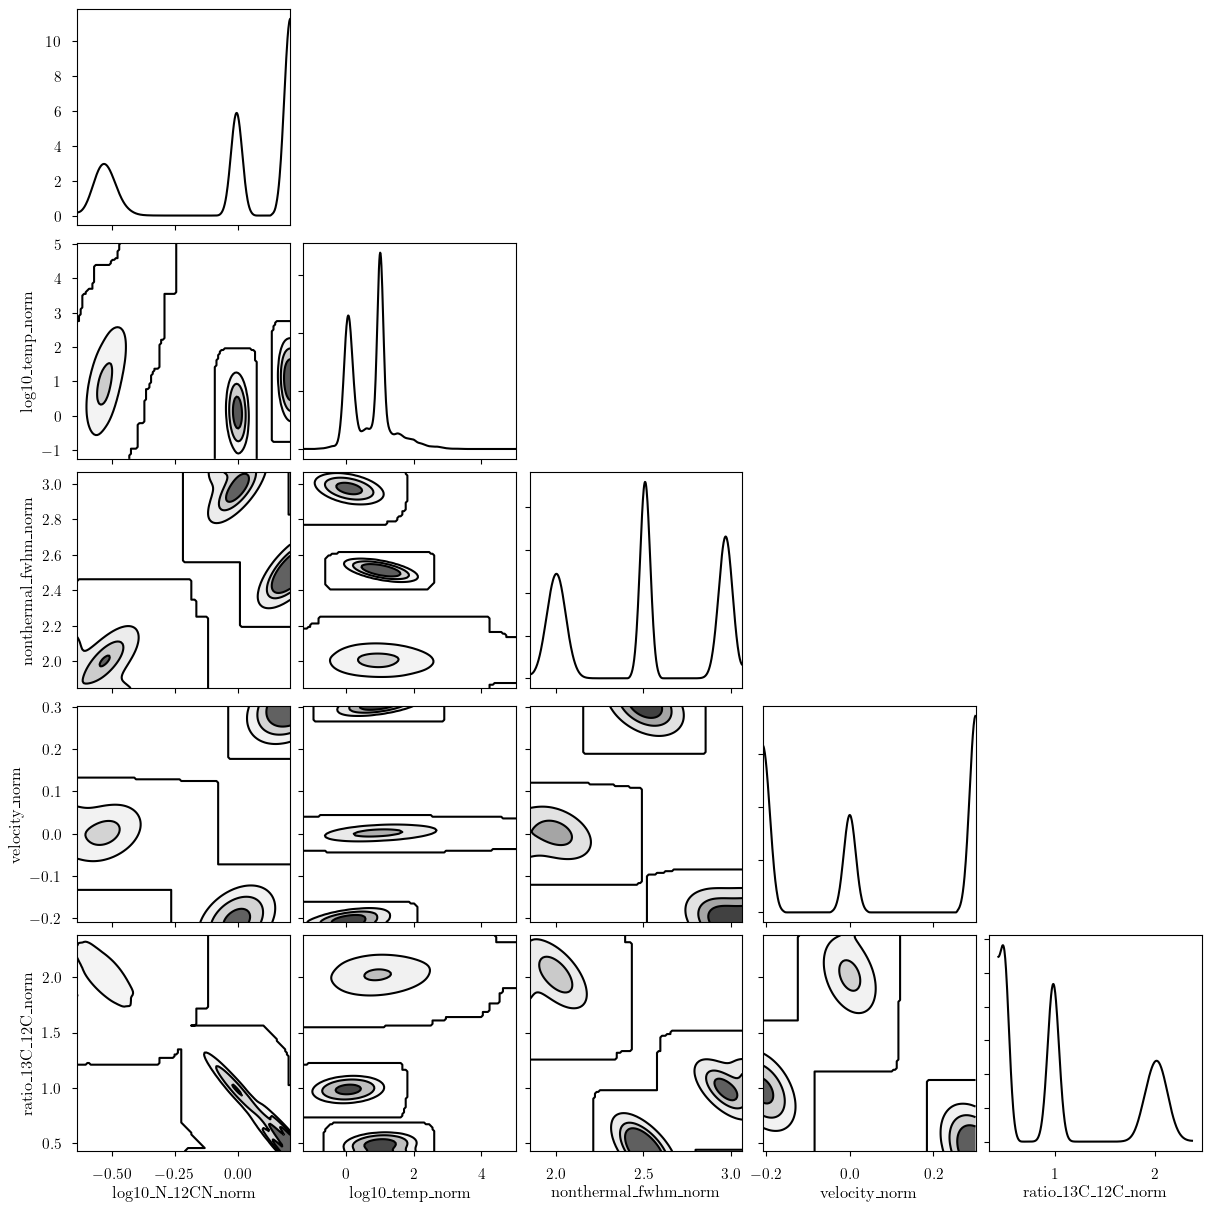

In [19]:
from bayes_spec.plots import plot_pair

plot_pair(
    model.trace.solution_0, # samples
    model.cloud_params, # var_names to plot
    labeller=model.labeller, # label manager
)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log$_{10}$ $T$ (K)'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm nt}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$v_{\\rm LSR}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='log$_{10}$ $N_{\\rm CN}$ (cm$^{-2}$)', ylabel='$^{13}{\\rm C}/^{12}{\\rm C}$'>,
        <Axes: xlabel='log$_{10}$ $T$ (K)'>,
        <Axes: xlabel='$\\Delta V_{\\rm nt}$ (km s$^{-1}$)'>,
        <Axes: xlabel='$v_{\\rm LSR}$ (km s$^{-1}$)'>,
        <Axes: xlabel='$^{13}{\\rm C}/^{12}{\\rm C}$'>]], dtype=object)

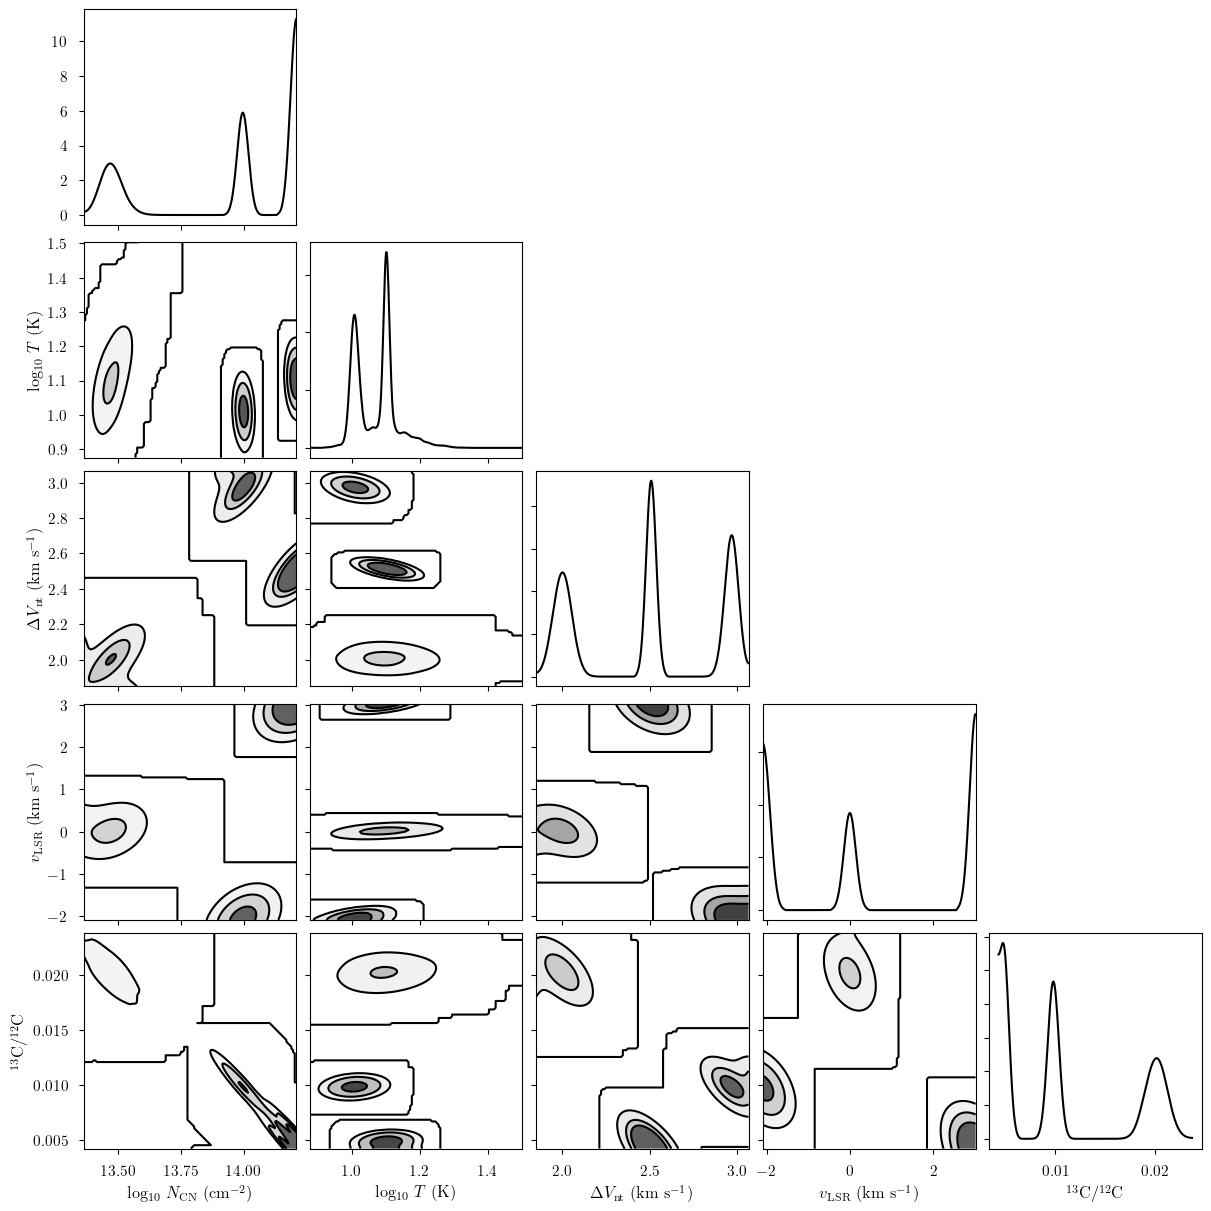

In [21]:
var_names = [var_name for var_name in model.deterministics if "rms" not in var_name]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [22]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -14011.869527330342


,mean,sd,hdi_16%,hdi_84%
log10_N_12CN[0],13.996,0.007,13.989,14.003
log10_N_12CN[1],14.201,0.002,14.198,14.203
log10_N_12CN[2],13.473,0.040,13.430,13.508
log10_temp[0],1.007,0.011,0.996,1.018
log10_temp[1],1.101,0.007,1.094,1.108
log10_temp[2],1.102,0.073,1.025,1.170
nonthermal_fwhm[0],2.968,0.029,2.944,3.000
nonthermal_fwhm[1],2.508,0.007,2.502,2.515
nonthermal_fwhm[2],2.001,0.046,1.954,2.046
velocity[0],-2.013,0.022,-2.034,-1.992
